<a href="https://colab.research.google.com/github/jdlg-42/TFG/blob/main/distancias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install igraph
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.0 MB/s eta 0:00:00


# Código para generar grafos de PSN

In [25]:
# Sitios importantes

sites = {
    "A2A_adenosine": [168, 169, 253, 277, 278],
    "A2A_G": [102, 110, 227, 231, 235],
    "beta2AR_epi_4ldo": [1113, 1114, 1193, 1203],
    "beta2AR_epi_3sn6": [113, 114, 193, 203],
    "beta2AR_G_4ldo": [1127, 1135, 1271, 1278],
    "beta2AR_G_3sn6": [134, 135, 138, 139, 229]
    }

Para receptor A2A de adenosina:

* 2YDO: cadena A, sites["A2A_adenosine"], sites["A2A_G"]
* 5G53: cadena A, sites["A2A_adenosine"], sites["A2A_G"]

Para receptor beta-2 adrenérgico:
* 4LDO: cadena A, sites["beta2AR_epi4ldo"], sites["beta2AR_G"]
* 3SN6: cadena R, sites["beta2AR_epi3sn6"], sites["beta2AR_G"]

In [39]:
# Configuración de secuencia y sitios alostérico y ortostérico
  # modificar para analizar el grafo para cada ID específico de interés

pdb_id = "2ydo".lower()
chain_id = "A"
sitio_A = sites["A2A_adenosine"] # sitio de unión del ligando alostérico
sitio_O = sites["A2A_G"] # sitio de unión de la proteína G

Caminos más cortos entre los nodos (168, 235) (color: orange):
Índice: 1
  Nodos involucrados: [168, 237, 235]
  Centralidad total: 750.15
  Longitud del camino: 3
  Color asignado: orange
Caminos más cortos entre los nodos (168, 231) (color: purple):
Índice: 2
  Nodos involucrados: [168, 171, 234, 231]
  Centralidad total: 1296.80
  Longitud del camino: 4
  Color asignado: purple
Caminos más cortos entre los nodos (169, 231) (color: green):
Índice: 3
  Nodos involucrados: [169, 171, 234, 231]
  Centralidad total: 1021.63
  Longitud del camino: 4
  Color asignado: green
Caminos más cortos entre los nodos (169, 235) (color: purple):
Índice: 4
  Nodos involucrados: [169, 171, 237, 235]
  Centralidad total: 784.58
  Longitud del camino: 4
  Color asignado: purple
Caminos más cortos entre los nodos (253, 231) (color: blue):
Índice: 5
  Nodos involucrados: [253, 257, 229, 231]
  Centralidad total: 619.26
  Longitud del camino: 4
  Color asignado: blue
Caminos más cortos entre los nodos (253

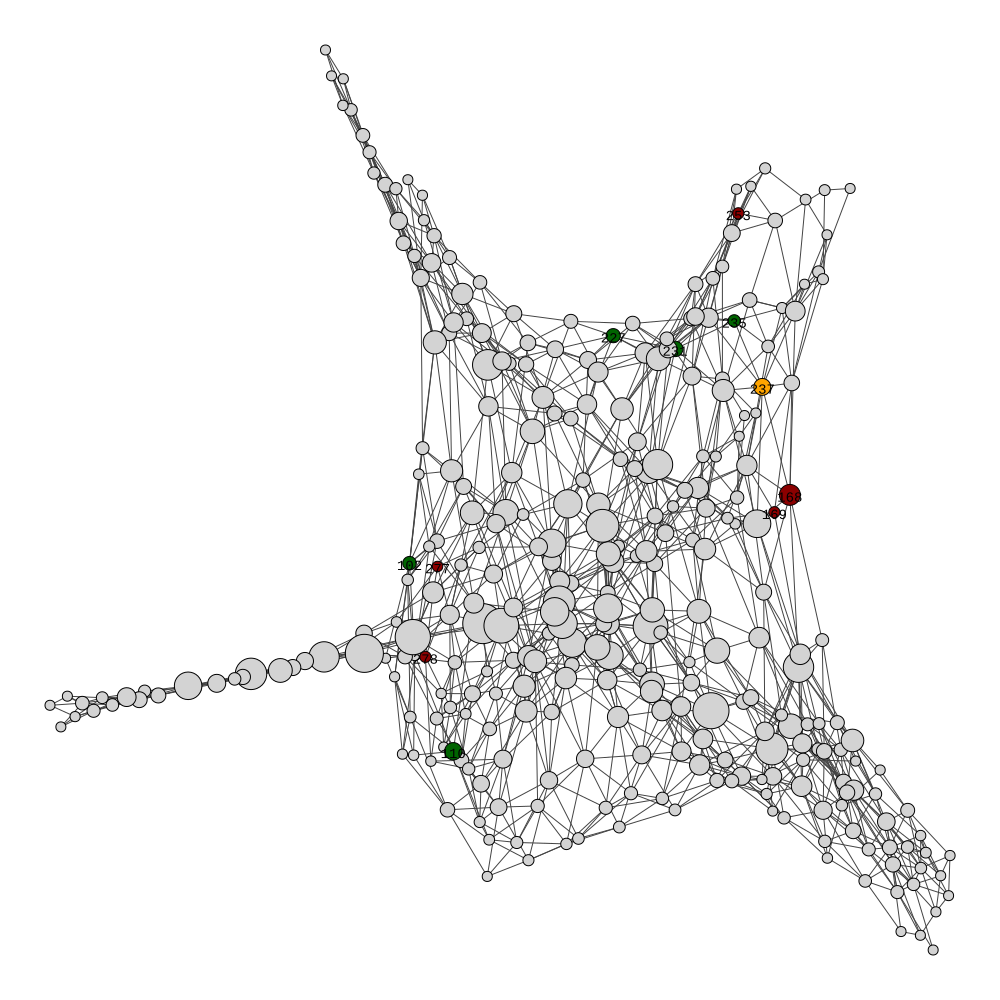

In [40]:
## Grafo de contacto de proteínas ##

# == Comandos de preparación ==

from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
from IPython.display import display, HTML

np.random.seed(42)
random.seed(42)

# Configuración de secuencia y

parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}.pdb")

# === Extracción de los CA ===
CA_coord = []
CA_resnums = []  # Lista que almacena la posición de los residuos

for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                for atom in residue:
                    if atom.get_name() == "CA":
                        CA_coord.append(atom.get_coord())
                        CA_resnums.append(residue.id[1])  # Número real del residuo

# Mapeo explítio de residuos: sirve para saber que índice le corresponde a
# cada residuo

resnum_to_node = {resnum: idx for idx, resnum in enumerate(CA_resnums)}


# === (Opcional) Extracción del ligando ===
alig_list = []
alig_coord = []

# si deseas incluir el ligando, descomenta esta sección
# for model in structure:
#     for chain in model:
#         if chain.id != "A":
#             continue
#         for residue in chain:
#             if residue.get_resname() == "ADN" and residue.id[1] == 400:
#                 for atom in residue:
#                     alig_list.append(atom.get_id())
#                     alig_coord.append(atom.get_coord())

atom_coord = CA_coord + alig_coord

# === Árbol de búsqueda y pares ===
tree = cKDTree(atom_coord)
atom_pairs = tree.query_pairs(r=10)

r_min = 4
r_max = 8
atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(atom_coord[i] - atom_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))

# === Cálculo de caminos más cortos ===
shortest_paths = []  # Lista para almacenar todos los caminos más cortos y sus colores
colors = ["gold", "blue", "green", "purple", "orange", "cyan"]  # Lista de colores que se asignarán a los caminos



# === Grafo ===
g = ig.Graph()
g.add_vertices(len(atom_coord))
for i, j in atom_pairsfilt:
    g.add_edge(i, j)

g.vs["size"] = 17


# Cálculo de los caminos más cortos
for a in sitio_A:
    for o in sitio_O:
        try:
            path = g.get_shortest_paths(a, to=o)[0]
            if path:
                shortest_paths.append({
                    "path": path,
                    "length": len(path),
                    "color": colors[len(shortest_paths) % len(colors)],  # Asignar un color por cada camino
                    "nodes": (a, o)
                })
        except:
            continue

# Calculamos el betweennes de los nodos y ajustamos los tamños en funnción a
# este valor

g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])


# === Añadir la métrica de centralidad a cada camino más corto ===
for path_info in shortest_paths:
    path = path_info["path"]
    centralities = [g.vs[node]["betweenness"] for node in path]
    path_info["centrality_score"] = np.mean(centralities)

# === Ordenar los caminos más cortos por suma de betweenness ===
shortest_paths.sort(key=lambda x: x["centrality_score"], reverse=True)


# Escalar tamaños entre 10 y 40
g.vs["size"] = [
    10 + 30 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

g.vs["color"] = ["lightgray"]
g.vs["label"] = [None] * len(g.vs)

# === Ligando ===
lig_start_idx = len(CA_coord)
lig_end_idx = lig_start_idx + len(alig_coord)
for i in range(lig_start_idx, lig_end_idx):
    g.vs[i]["color"] = "navy"
    g.vs[i]["label"] = alig_list[i - lig_start_idx]

shortest_paths.sort(key=lambda x: x["length"])

# === Asignación de colores a los caminos más cortos ===
for idx, path_info in enumerate(shortest_paths):
    color = path_info["color"]
    path = path_info["path"]
    # Imprimir la información de cada shortest path
    print(f"Caminos más cortos entre los nodos {path_info['nodes']} (color: {color}):")
    print(f"Índice: {idx+1}")
    print(f"  Nodos involucrados: {path_info['path']}")
    print(f"  Centralidad total: {path_info['centrality_score']:.2f}")
    print(f"  Longitud del camino: {path_info['length']}")
    print(f"  Color asignado: {path_info['color']}")
    print("="*50)

# === Preguntar al usuario qué camino desea visualizar ===
try:
    selection = int(input("Introduce el número del camino más corto que deseas visualizar (0 para no representar ninguno): "))
    if 1 <= selection <= len(shortest_paths):
        chosen_path = shortest_paths[selection - 1]
        path = chosen_path["path"]
        color = chosen_path["color"]

        for node in path:
            g.vs[node]["color"] = color
            g.vs[node]["label"] = str(node)
    else:
        print("Número fuera de rango. No se coloreará ningún camino.")
except ValueError:
    print("Entrada no válida. No se coloreará ningún camino.")


# === Sitios de interés (debes definir previamente el diccionario 'sites') ===
for aa in sitio_A:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkred"
        g.vs[aa]["label"] = str(aa)

for aa in sitio_O:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkgreen"
        g.vs[aa]["label"] = str(aa)

# === Plot ===
layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout, bbox=(1000, 1000), margin=50)

In [68]:
top_n = 50
btw_sorted = sorted(enumerate(g.vs["betweenness"]), key=lambda x: x[1], reverse=True)
top_nodes = [idx for idx, val in btw_sorted[:top_n]]

i=1
print("Top nodos por betweenness centrality en 2YDO:")
for idx in top_nodes:
    print(f"{i}. Nodo {idx}: betweenness = {g.vs[idx]['betweenness']:.2f}")
    i+=1

Top nodos por betweenness centrality en 2YDO:
1. Nodo 49: betweenness = 2858.34
2. Nodo 248: betweenness = 2797.52
3. Nodo 250: betweenness = 2278.61
4. Nodo 78: betweenness = 2173.28
5. Nodo 88: betweenness = 2095.14
6. Nodo 208: betweenness = 2066.04
7. Nodo 259: betweenness = 2063.54
8. Nodo 209: betweenness = 2039.32
9. Nodo 168: betweenness = 1918.80
10. Nodo 75: betweenness = 1890.23
11. Nodo 179: betweenness = 1841.05
12. Nodo 39: betweenness = 1828.00
13. Nodo 86: betweenness = 1826.05
14. Nodo 54: betweenness = 1754.29
15. Nodo 85: betweenness = 1731.79
16. Nodo 205: betweenness = 1680.17
17. Nodo 257: betweenness = 1670.25
18. Nodo 93: betweenness = 1621.47
19. Nodo 87: betweenness = 1597.97
20. Nodo 24: betweenness = 1589.08
21. Nodo 216: betweenness = 1574.89
22. Nodo 215: betweenness = 1547.17
23. Nodo 154: betweenness = 1524.34
24. Nodo 252: betweenness = 1512.16
25. Nodo 38: betweenness = 1472.75
26. Nodo 167: betweenness = 1418.02
27. Nodo 251: betweenness = 1411.00
28.

[162, 163, 237, 261, 262] [96, 104, 211, 215, 219]
Caminos más cortos entre los nodos (262, 219) (color: gold):
Índice: 1
  Nodos involucrados: [262, 229, 225, 221, 219]
  Centralidad total: 1159.44
  Longitud del camino: 5
Caminos más cortos entre los nodos (261, 219) (color: blue):
Índice: 2
  Nodos involucrados: [261, 229, 225, 221, 219]
  Centralidad total: 792.44
  Longitud del camino: 5
Caminos más cortos entre los nodos (262, 96) (color: green):
Índice: 3
  Nodos involucrados: [262, 49, 45, 88, 92, 96]
  Centralidad total: 1511.21
  Longitud del camino: 6
Caminos más cortos entre los nodos (261, 96) (color: purple):
Índice: 4
  Nodos involucrados: [261, 264, 268, 89, 92, 96]
  Centralidad total: 1272.14
  Longitud del camino: 6
Caminos más cortos entre los nodos (237, 219) (color: green):
Índice: 5
  Nodos involucrados: [237, 233, 230, 226, 222, 219]
  Centralidad total: 1133.32
  Longitud del camino: 6
Caminos más cortos entre los nodos (262, 215) (color: cyan):
Índice: 6
  Nod

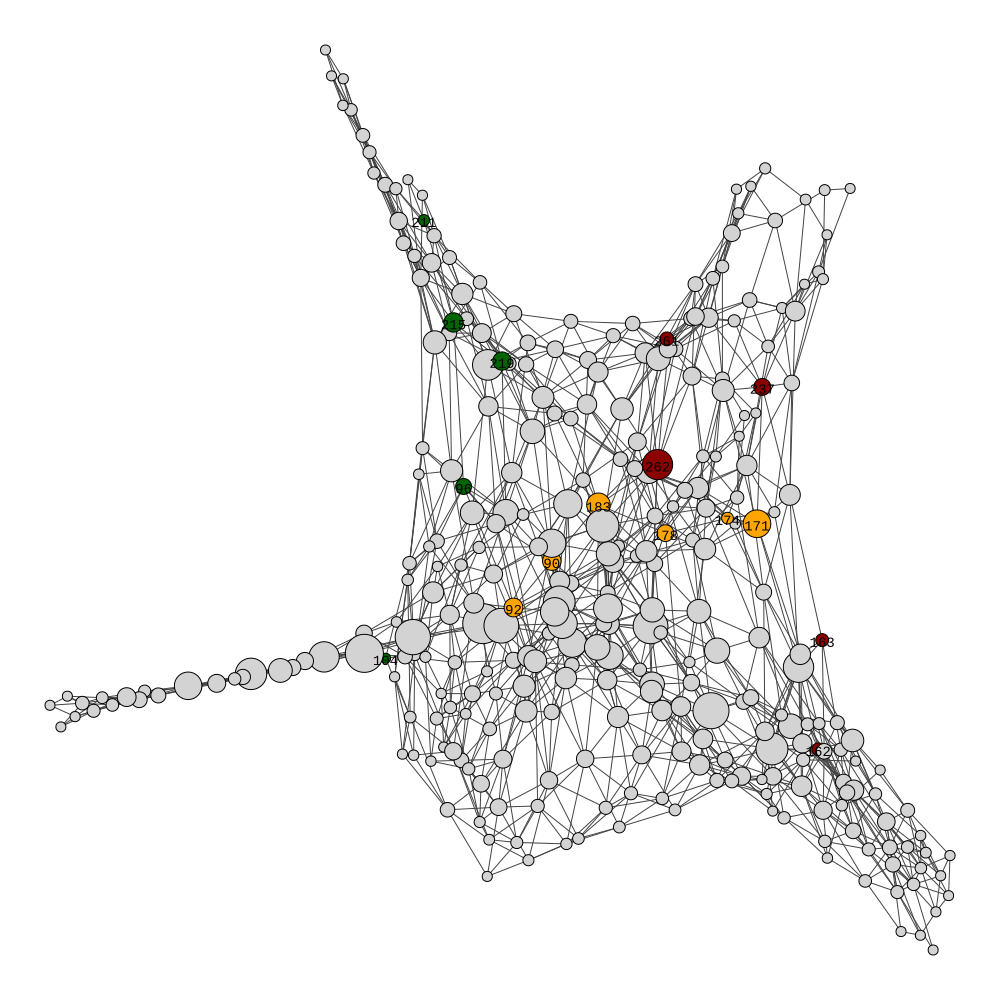

In [38]:
## Grafo de contacto de proteínas ##

# == Comandos de preparación ==
from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)

# Pruebas

pdb_id = "2ydo".lower()
chain_id = "A"
sitio_A_residues = sites["A2A_adenosine"] # sitio de unión del ligando alostérico
sitio_O_residues = sites["A2A_G"] # sitio de unión de la proteína G

# === Lectura del PDB ===
parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}.pdb")

# === Extracción de los CA ===
CA_coord = []
CA_resnums = []  # Número real del residuo
for model in structure:
    for chain in model:
        if chain.id == chain_id:
            for residue in chain:
                if "CA" in residue:
                    CA_coord.append(residue["CA"].get_coord())
                    CA_resnums.append(residue.id[1])  # Número de residuo

# Crear mapeo: número de residuo → índice de nodo
resnum_to_node = {resnum: idx for idx, resnum in enumerate(CA_resnums)}

# === (Opcional) Extracción del ligando ===
alig_list = []
alig_coord = []

# atom_coord contiene CA + ligando (si lo hay)
atom_coord = CA_coord + alig_coord

# === Árbol de búsqueda y filtrado de pares ===
tree = cKDTree(atom_coord)
atom_pairs = tree.query_pairs(r=10)

r_min = 4
r_max = 8
atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(atom_coord[i] - atom_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))

# === Creación del grafo ===
g = ig.Graph()
g.add_vertices(len(atom_coord))
for i, j in atom_pairsfilt:
    g.add_edge(i, j)

# === Definir sitios A y O (convertir de número de residuo a índice de nodo) ===
sitio_A = [resnum_to_node[r] for r in sitio_A_residues if r in resnum_to_node]
sitio_O = [resnum_to_node[r] for r in sitio_O_residues if r in resnum_to_node]

print(sitio_A, sitio_O)

# === Cálculo de caminos más cortos ===
shortest_paths = []
colors = ["gold", "blue", "green", "purple", "orange", "cyan"]

for a in sitio_A:
    for o in sitio_O:
        try:
            path = g.get_shortest_paths(a, to=o)[0]
            if path:
                shortest_paths.append({
                    "path": path,
                    "length": len(path),
                    "color": colors[len(shortest_paths) % len(colors)],
                    "nodes": (a, o)
                })
        except:
            continue

# === Betweenness y escalado de tamaño de nodos ===
g.vs["betweenness"] = g.betweenness()
max_btw = max(g.vs["betweenness"])
min_btw = min(g.vs["betweenness"])
g.vs["size"] = [
    10 + 30 * ((btw - min_btw) / (max_btw - min_btw + 1e-9))
    for btw in g.vs["betweenness"]
]

# === Etiquetas ===
#g.vs["label"] = [str(r) for r in CA_resnums] + [None]*len(alig_coord)
g.vs["color"] = ["lightgray"] * len(g.vs)

# === Coloreo de ligando (si lo hay) ===
lig_start_idx = len(CA_coord)
lig_end_idx = lig_start_idx + len(alig_coord)
for i in range(lig_start_idx, lig_end_idx):
    g.vs[i]["color"] = "navy"
    g.vs[i]["label"] = alig_list[i - lig_start_idx]

# === Métrica de centralidad en los caminos más cortos ===
for path_info in shortest_paths:
    path = path_info["path"]
    centralities = [g.vs[node]["betweenness"] for node in path]
    path_info["centrality_score"] = np.mean(centralities)

# Ordenar por centralidad
shortest_paths.sort(key=lambda x: x["centrality_score"], reverse=True)

# === Mostrar caminos más cortos ===
shortest_paths.sort(key=lambda x: x["length"])
for idx, path_info in enumerate(shortest_paths):
    print(f"Caminos más cortos entre los nodos {path_info['nodes']} (color: {path_info['color']}):")
    print(f"Índice: {idx+1}")
    print(f"  Nodos involucrados: {path_info['path']}")
    print(f"  Centralidad total: {path_info['centrality_score']:.2f}")
    print(f"  Longitud del camino: {path_info['length']}")
    print("="*50)

# === Selección de camino para visualización ===
try:
    selection = int(input("Introduce el número del camino más corto que deseas visualizar (0 para no representar ninguno): "))
    if 1 <= selection <= len(shortest_paths):
        chosen_path = shortest_paths[selection - 1]
        path = chosen_path["path"]
        color = chosen_path["color"]
        for node in path:
            g.vs[node]["color"] = color
            g.vs[node]["label"] = str(node)
    else:
        print("Número fuera de rango. No se coloreará ningún camino.")
except ValueError:
    print("Entrada no válida. No se coloreará ningún camino.")

# === Colorear sitios A y O ===
for aa in sitio_A:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkred"
        g.vs[aa]["label"] = str(aa)

for aa in sitio_O:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkgreen"
        g.vs[aa]["label"] = str(aa)

# === Visualización final ===
layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout, bbox=(1000, 1000), margin=50)
